## Нейросети - основы.
### Ноутбук составлен по воспоминаниям из разных курсов, в первую очередь Stanford cs231n, а также по материалам с сайта Eli Bendersky

### 1. Простейший классификатор на основе одного нейрона. Градиентный спуск

Попробуем сделать простейший нейрон. n входов, 1 выход, от n входов сигнал передается с весами w, в самом нейроне действует функция активации, работающая с суммой сигналов от входов. Для начала воспользуемся классической сигмоидой. 

Пока реализуем все без numpy, numpy будем использовать только для функции plot_decision_regions, так как она на входе требует ndarray.

In [1]:
import math

In [2]:
def sigm(x):
    return 1 / (1 + math.exp(-x))

In [3]:
import matplotlib.pyplot as plt

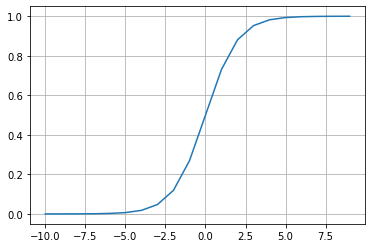

In [5]:
X = [x for x in range(-10, 10)]
Y = [sigm(x) for x in X]
plt.plot(X, Y)
plt.grid()
plt.show()

In [6]:
class Neuron:
    
    def __init__(self, n, activation):
        self.w = [0.5 for i in range(n)] # будем пока пользоваться статической инициализацией весов
        self.act = activation
        
    def forward(self, X):
        result = 0
        for x, w in zip(X, self.w):
            result += x * w
        return self.act(result)

Пусть будет 2 признака, подаваемых на вход нейрона

In [13]:
X1 = [-4, 4]
X2 = [1, 2]
X3 = [-1, -2]
N1 = Neuron(2, sigm)
print(N1.forward(X1), N1.forward(X2), N1.forward(X3))
print(1 / (1 + math.exp(0)), 1 / (1 + math.exp(-1.5)), 1 / (1 + math.exp(1.5)))

0.5 0.8175744761936437 0.18242552380635635
0.5 0.8175744761936437 0.18242552380635635


В направлении forward работает. Теперь нейрон нужно обучить. 
Возьмем задачу классификации и логистическую функци потерь:

In [14]:
def logloss(y, y_hat):
    eps = 1e-10
    return -y * math.log(y_hat + eps, 2) - (1 - y) * math.log(1 - y_hat + eps, 2)

Создадим выборки

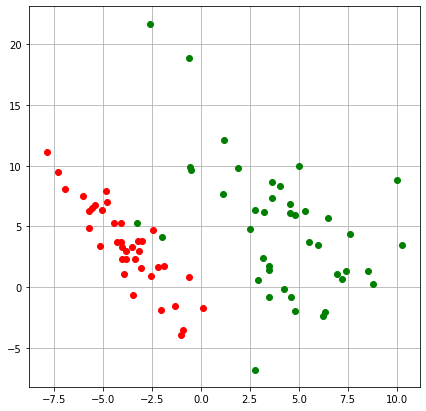

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

X, Y = make_classification(n_samples = 100, n_features = 2, 
                           n_informative = 2, n_classes = 2, 
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           scale = 4,
                           random_state = 2)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=20, random_state = 42)

fig = plt.figure(figsize=(7, 7))

plt.plot(train_X[np.where(train_Y==0), 0], train_X[np.where(train_Y==0), 1], 'ro')
plt.plot(train_X[np.where(train_Y==1), 0], train_X[np.where(train_Y==1), 1], 'go')
plt.grid()

plt.show()

Посмотрим, как выглядит зависимость эмпирического риска от весов нейрона. Будет интересно отследить, как будет меняться эмпирический риск модели в процессе обучения.

In [16]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [18]:
def makeData(X_train, Y_train):
    W1 = np.arange (-20, 20, 0.4)
    W2 = np.arange (-20, 20, 0.4)
    w1grid, w2grid = np.meshgrid(W1, W2)
    
    lossgrid = np.zeros((len(W1), len(W2)))
    for i, w1 in enumerate(W1):
        for j, w2 in enumerate(W2):
            N = Neuron(2, sigm)
            N.w = [w1, w2]
            result = []
            for x, y in zip(X_train, Y_train):
                y_hat = N.forward(x)
                result.append(logloss(y, y_hat))
            lossgrid[j, i] = sum(result) / len(result)

    return w1grid, w2grid, lossgrid

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

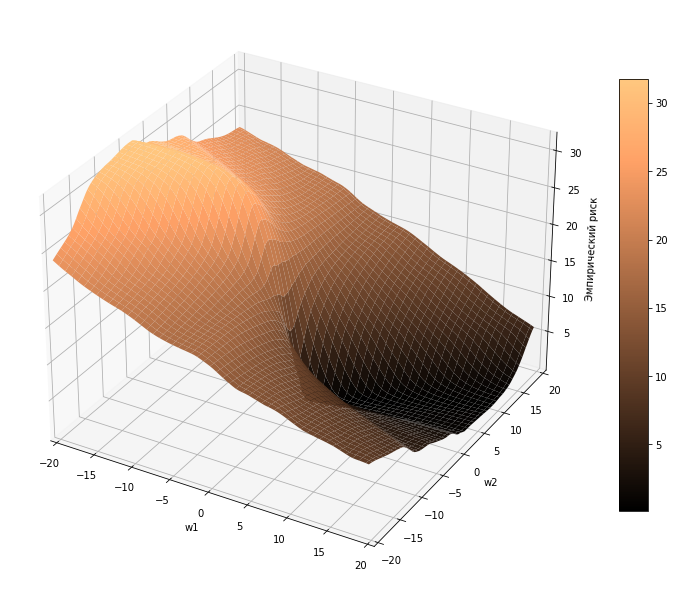

In [49]:
x, y, U = makeData(train_X, train_Y)
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(axes)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_zlabel('Эмпирический риск')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.copper)
fig.colorbar(surf, shrink=0.5, aspect=15)
pylab.show()

Необходимо подобрать веса w1 и w2 так, чтобы минимизировать функцию ошибки. Если мы инициализируем веса любыми значениями, отличными от оптимальных, необходимо изменять их таким образом, чтобы значение функции ошибки на обучающей выборке снижалось. Оптимальным изменением весов с целью снижения значения функции будет снижение в направлении, противоположном градиенту функции в рассматриваемой точке. 

Градиент - это вектор-функция, координатами которой являются частные производные. Почему вектор? Потому, что имеет координаты - по числу переменных. Почему функция? Потому, что эти координаты зависят от переменных. Градиент функции потерь, представленной на трехмерном графике выше, - это вектор в плоскости (w1, w2).

#### $$ gradL(w_1, w_2) = \left( \frac{\partial(L(w_1, w_2))}{\partial(w_1)}, \frac{\partial(L(w_1, w_2))}{\partial(w_2)} \right) $$
Частные производные показывают скорость роста функции по направлению соответствующей оси. Быстрее всего функция в точке растет в направлении своего градиента. Соответственно, чтобы добиться наискорейшего снижения значения функции, необходимо двигаться в направлении антиградиента. Как это сделать? Найти частные производные функции потерь по w1 и w2 и двигаться в пространстве (w1, w2) в противоположном этим частным производным направлении шагами определенной величины (learning rate). Это и есть метод градиентного спуска.

Проблема в том, что функция потерь зависит не только от w1 и w2, но и от обучающей выборки. Если бы зависимость от каких-либо переменных, кроме w1 и w2, отсутствовала, мы могли бы аналитически вычислять значение градиента в каждой точке. Или вообще нашли бы значение минимума функции по w1 и w2, приравняв к нулю частные производные. Вместо этого частные производные по переменным придется вычислять, рассчитывая значение функции потерь по обучающей выборке в каждой интересующей нас точке. 

#### $$ logloss(y, \hat y(X, W)) =  -ylog_2(\hat y(X, W)) - (1-y)(log_2(1-\hat y(X, W))) = $$
#### $$ = -ylog_2(\frac{1}{1+e^{-(x_1w_1 + x_2w_2)}}) - (1-y)log_2(1- \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}})$$

Частные производные функции потерь по w1 и w2 равны:
#### $$\frac{\partial logloss(y, \hat y(X, W))}{\partial w_1} = \frac{x_1}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
#### $$\frac{\partial logloss(y, \hat y(X, W))}{\partial w_2} = \frac{x_2}{ln2}\left( \frac{1}{1+e^{-(x_1w_1 + x_2w_2)}} - y\right)$$
В скобках - разность между выходом нейрона и действительным значением зависимой переменной.

Реализуем метод градиентного спуска, пока не стохастический. Формально правило для изменения весов запишется так:
#### $$w:=w - \eta \nabla Q(w) = w - \frac{\eta}{n}\sum_{i=1}^n{\nabla Q_i(w)} $$
, где w - искомый вектор параметров модели, минимизирующий эмпирический риск, сумма берется по всем элементам обучающей выборки. 
Так как w - это вектор, градиенты по обучающей выборке на каждом шаге необходимо накапливать отдельно для каждого компонента вектора (переменные w0_sum и w1_sum в алгоритме ниже). 

In [52]:
def gDescent(X_train, Y_train, N1, lr = 0.1, criterion = 0.01, debug = 0):
    
    """ Градиентный спуск для одного нейрона с двумя весами. 
    
    
    Эмпирический риск считается на каждом шаге и сохраняется наряду с текущими весами модели, 
    чтобы можно было отследить изменение суммы значений функции потерь на трехмерном графике.
    
    Аргументы: 
    X_train, Y_train -- элементы и ответы обучающей выборки
    N1 -- нейрон, который необходимо обучить. В этой простейшей функции реализация для двух признаков.
    lr -- learning rate
    criterion -- критерий остановки, усредненное значение эмпирического риска, при которой модель считается обученной
    debug -- уровень логгирования. 
    """
    curr_loss = 1e3
    iteration = 0
    w0s = []
    w1s = []
    lossfunc = []
    
    while curr_loss > criterion and iteration < 150:
        
        losses = []
        Y_hat = []
        w1_sum = w2_sum = 0
        
        # В нестохастической версии градиентного спуска на каждой итерации градиент рассчитывается по всей выборке
        for x, y in zip(X_train, Y_train):
            y_hat = N1.forward(x)
            Y_hat.append(y_hat)
            losses.append(logloss(y, y_hat))
            w1_sum += x[0] / math.log(2) * (y_hat - y)
            w2_sum += x[1] / math.log(2) * (y_hat - y)
            
        curr_loss = sum(losses) / len(losses)
        acc = accuracy(Y_train, Y_hat)
        w0s.append(N1.w[0])
        w1s.append(N1.w[1])
        lossfunc.append(curr_loss)
        
        if debug == 1: print(f'\niteration {iteration}: curr_loss = {curr_loss}, accuracy = {acc}')
        
        N1.w[0] += (-1) * lr * 1 / len(Y_train) * w1_sum # домножаем на -1, так как для поиска минимума мы должны двигаться в направлении, противоположном градиенту
        N1.w[1] += (-1) * lr * 1 / len(Y_train) * w2_sum # домножаем на -1, так как для поиска минимума мы должны двигаться в направлении, противоположном градиенту
        if debug == 1: print(f'new weights: {N1.w}')
        
        iteration += 1
    return w0s, w1s, lossfunc

In [53]:
def accuracy(Y, Y_hat):
    errors = 0
    for y, y_hat in zip(Y, Y_hat):
        if round(y_hat) != y:
            errors += 1
    return (len(Y) - errors) / len(Y)

Создадим примитивный классификатор на основе одного нейрона. Он потребуется, чтобы подать его на вход функции plot_decision_regions.

In [54]:
class PrimitiveNN:
    
    def __init__(self, Neuron):
        self.N = Neuron
        
    def predict(self, X_test):
        result = []
        for x in X_test:
            result.append(round(self.N.forward(x)))
        return np.array(result)

Зададим стартовые веса нейрона намеренно в области с высоким эмпирическим риском, чтобы посмотреть, как сеть будет обучаться на большом диапазоне W

In [55]:
N1 = Neuron(2, sigm)
N1.w = [-20, -2]

In [56]:
w0s, w1s, lossfunc = gDescent(train_X, train_Y, N1, lr = 0.03, debug = 0)

In [57]:
N1.w

[0.7088649346628064, 0.1822565938422673]

In [58]:
primNN = PrimitiveNN(N1)

Один нейрон строит разделяющую поверхность в виде прямой:

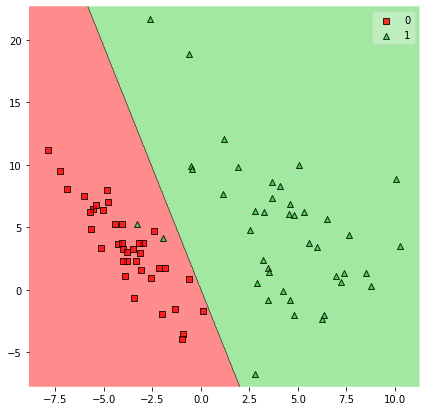

In [59]:
from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, primNN, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Посмотрим, как менялось значение эмпирического риска на каждом шаге обучения

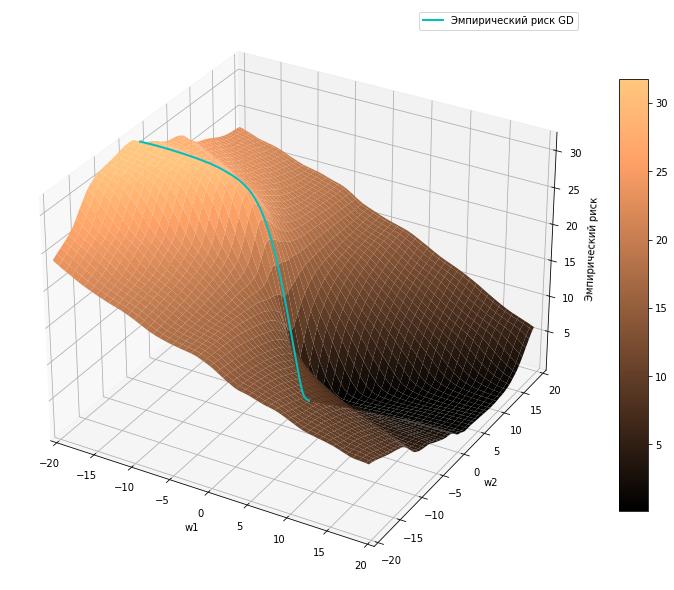

In [62]:
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(axes)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_zlabel('Эмпирический риск')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.copper)
fig.colorbar(surf, shrink=0.5, aspect=15)
axes.plot(np.array(w0s), np.array(w1s), np.array(lossfunc), label='Эмпирический риск GD', color = 'c', linewidth=2, zorder = 10)
axes.legend()
pylab.show()

По графику видно, что из точки с наибольшим эмпирическим риском параметры модели успешно модифицируются и по кратчайшему пути следуют в область минимума функции

Реализуем стохастический градиентный спуск. Вместо того, чтобы рассчитывать градиентный шаг, суммируя градиенты по всем экземплярам обучающей выборки, будем случайным образом брать несколько экземпляров обучающей выборки и считать градиентный шаг только по ним. Это позволит ускорить обучение, особенно на больших обучающих выборках.

Для более корректного отображения эмпирического риска на графике, а также чтобы более честно считать accuracy, будем на каждой итерации пересчитывать точность и эмпирический риск по всей обучающей выборке. Градиентный шаг при этом будем рассчитывать, опираясь только на mibi_batch.

In [63]:
import random

def SGD(X_train, Y_train, N1, lr = 0.1, criterion = 0.01, batch_size = 8, debug = 0):
    
    """ Стохастический градиентный спуск для одного нейрона с двумя весами. 
    
    
    Эмпирический риск считается на каждом шаге по всей обучающей выборке и сохраняется наряду с текущими весами модели, 
    чтобы можно было отследить изменение суммы значений функции потерь на трехмерном графике.
    
    Аргументы: 
    X_train, Y_train -- элементы и ответы обучающей выборки
    N1 -- нейрон, который необходимо обучить. В этой простейшей функции реализация для двух признаков.
    lr -- learning rate
    criterion -- критерий остановки, усредненное значение эмпирического риска, при которой модель считается обученной
    batch_size -- количество экземпляров обучающей выборки, используемое для расчета градиента на одной итерации
    debug -- уровень логгирования. 
    """
    
    curr_loss = 1e3
    iteration = 0
    w0s = []
    w1s = []
    lossfunc = []
    while curr_loss > criterion and iteration < 150:
        
        losses = []
        Y_hat = []
        
        for x, y in zip(X_train, Y_train):
            y_hat = N1.forward(x)
            Y_hat.append(y_hat)
            losses.append(logloss(y, y_hat))
            
        curr_loss = sum(losses) / len(losses)
        acc = accuracy(Y_train, Y_hat)
        w0s.append(N1.w[0])
        w1s.append(N1.w[1])
        lossfunc.append(curr_loss)
        
        if debug == 1: print(f'\niteration {iteration}: curr_loss = {curr_loss}, accuracy = {acc}')
        
        batch_index = random.sample([i for i in range(len(Y_train))], batch_size)
        w1_sum = w2_sum = 0
        for x, y in zip(X_train[batch_index], Y_train[batch_index]):
            y_hat = N1.forward(x)
            w1_sum += x[0] / math.log(2) * (y_hat - y)
            w2_sum += x[1] / math.log(2) * (y_hat - y)
        
        N1.w[0] += (-1) * lr * 1 / len(batch_index) * w1_sum
        N1.w[1] += (-1) * lr * 1 / len(batch_index) * w2_sum
        if debug == 1: print(f'new weights: {N1.w}')
        
        iteration += 1
    return w0s, w1s, lossfunc

Аналогично, инициализируем веса в области высокого эмпирического риска

In [64]:
N2 = Neuron(2, sigm)
N2.w = [-20, -2]

In [65]:
w0s, w1s, lossfunc = SGD(train_X, train_Y, N2, lr = 0.03, debug = 0)

In [66]:
N2.w

[0.7070505180290835, 0.18344916744521583]

In [67]:
primNN2 = PrimitiveNN(N2)

Разделяющая поверхность построена успешно:

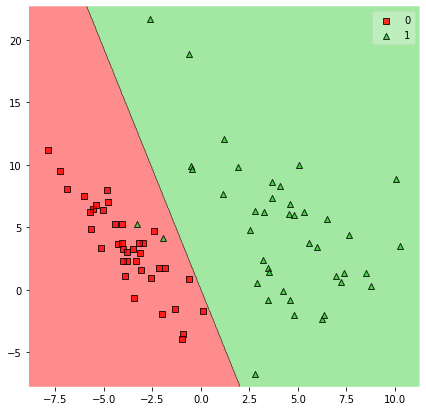

In [68]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, primNN2, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

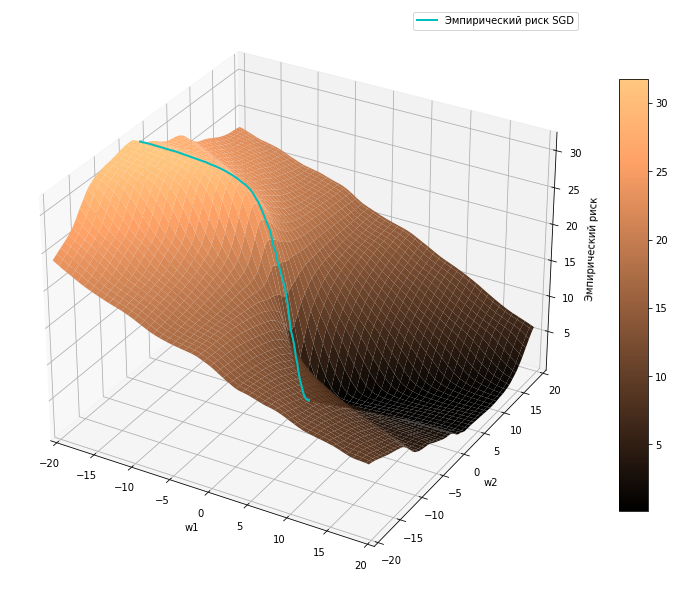

In [70]:
fig = pylab.figure(figsize=(10, 12))
axes = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(axes)
axes.set_xlabel('w1')
axes.set_ylabel('w2')
axes.set_zlabel('Эмпирический риск')
axes.set_xlim(-20, 20)
axes.set_ylim(-20, 20)
surf = axes.plot_surface(x, y, U, cmap=cm.copper)
fig.colorbar(surf, shrink=0.5, aspect=15)
axes.plot(np.array(w0s), np.array(w1s), np.array(lossfunc), label='Эмпирический риск SGD', color = 'c', linewidth=2, zorder = 10)
axes.legend()
pylab.show()

Видно, что несмотря на то, что в SGD используется batch размером в 8 экземпляров вместо полного обучающего датасета длиной 80, сходимость обоих алгоритмов практически одинаковая - уровень эмпирического риска меньше 1 достигается в обоих случаях на 116 шаге при идентичной lr = 0.03. По графику SGD видно, что он чуть менее гладкий, но спуск идет по той же траектории в тот же минимум.

### 2. Метод обратного распространения ошибки

Реализуем теперь нейросеть на основе Fully Connected Layers и нелинейных функций активации с помощью numpy. Нейросеть нужно будет делать из компонент - слоев, чтобы можно было последовательно через эти слои запустить forward pass и backward pass. Forward pass аналогичен реализованному выше механизму получения выходного сигнала с единичного нейрона: на вход слоя подается входной сигнал, слой выполняет требуемые преобразования и отдает выходной сигнал, который далее обрабатывается следующим слоем или выдает результат классификации/регрессии, на основе которого рассчитывается ошибка. 

Концепция backward pass сложнее. Для обучения нейросети методом градиентного спуска необходимо уметь рассчитывать частные производные от функции потерь по каждому параметру неросети, чтобы делать градиентный шаг. Производные по параметрам можно рассчитать аналитически, но для крупной нейросети аналитический расчет будет недопустимо сложным. Альтернативным методом расчета градиентов является механизм обратного распространения ошибки backpropagation, основанный на т.н. chain rule, или правиле взятия производной сложной функции. 

### $$\frac{\partial f(y(x))}{\partial x} = \frac{\partial f(y)}{\partial y(x)}\frac{\partial y(x)}{\partial x}$$

При проходе forward pass каждый последующий слой нейросети принимает на вход сигнал от предыдущего слоя, выполняет преобразование в соответствии со своей логикой и передает выходной сигнал дальше по сети. Соответственно, частную производную по какому-либо параметру в текущем слое можно рассчитать через произведение "входящего" градиента (частная производная функции потерь по выходу из рассматриваемого слоя) и градиента функции в рассматриваемом слое по искомому параметру.

При прохождении backward pass кроме частных производных по параметрам рассматриваемого слоя необходимо рассчитывать частные производные по входам с предыдущего уровня. Именно эти производные станут "входящими" для расчета градиентов на предыдущем уровне. 

Релизуем линейный слой (Fully Connected Layer) с учетом описанной логики. Пусть на вход линейного слоя подается batch размером N, каждый экземпляр выборки представлен D-признаками. Пусть выход линейного слоя представлен M - нейронами. Тогда на выходе слоя будем получать batch размером N x M. Соответственно, веса линейного слоя образуют матрицу W размерностью (D x M)

В рамках механизма backpropagation необходимо рассчитать два вида градиентов:
### $$ \frac{\partial L(X, W)}{\partial W} $$
для расчета градиентного шага и 
### $$ \frac{\partial L(X, W)}{\partial X} $$
для передачи градиентов на предыдущий слой

Для расчета обеих матриц необходимо знать "входящий" градиент, т.е., производную функции потерь по выходу из рассматриваемого слоя. Обозначим выход из нашего линейного слоя Y, его размерность будет N x M. Так как значение функции потерь - это скаляр, его производная по матрице Y будет иметь ту же размерность, что и сама матрица Y. То есть, на вход нашего линейного слоя в рамках механизма backpropagation мы должны получить матрицу
### $$ \frac{\partial L}{\partial Y} = \begin{pmatrix} \frac{\partial L}{\partial y_{1,1}}&. . .&\frac{\partial L}{\partial y_{1,M}}\\\frac{\partial L}{\partial y_{N,1}}&. . .& \frac{\partial L}{\partial y_{N,M}}\end{pmatrix}$$

Дальше, пользуясь chain rule, получим

### $$\frac{\partial L(X, W)}{\partial W} = \frac{\partial L(X, W)}{\partial Y}\frac{\partial Y}{\partial W} $$
### $$\frac{\partial L(X, W)}{\partial X} = \frac{\partial L(X, W)}{\partial Y}\frac{\partial Y}{\partial X} $$
где $\frac{\partial Y}{\partial W}$ и $\frac{\partial Y}{\partial X}$ - Якобианы, содержащие частные производные каждого компонента матрицы Y по каждому компоненту матриц X и W соответственно.

С Якобианами в общем виде работать непрактично ввиду их разреженности и большого размера, поэтому (здесь без вывода, вывод в конспекте) для частных производных по X и по W линейного слоя используются готовые формулы:
### $$\frac{\partial L(X, W)}{\partial W} = X^T\frac{\partial L(X, W)}{\partial Y}$$
### $$\frac{\partial L(X, W)}{\partial X} = \frac{\partial L(X, W)}{\partial Y}W^T$$

In [ ]:
class Linear:
    
    def __init__(self, inp, out):
        self.inp = inp
        self.out = out
        
        # self.W = np.random.default_rng().uniform(-0.5, 0.5, (inp, out)).astype(np.float32)
        stdv = 1.0 / np.sqrt(inp)
        self.W = np.random.default_rng().uniform(-stdv, stdv, (inp, out)).astype(np.float32)
        
        
        self.X_ = None # кэш для хранения входов с предыдущего уровня для расчета градиентов на backward pass
        
    def forward(self, X):
        self.X_ = X.astype(np.float32)
        return np.dot(X.astype(np.float32), self.W)
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0): #upstr_grad - входящий градиент от уровня, находящегося ближе к выходу нейросети
        delta_W = np.dot(np.transpose(self.X_), upstr_grad.astype(np.float32))
        self.W += (-1) * lr * delta_W # домножаем на -1, так как необходимо идти в противоположную от градиента сторону
        if debug == 2: print(f'Linear Layer: gradients = {delta_W}')
        return np.dot(upstr_grad.astype(np.float32), np.transpose(self.W))

In [ ]:
class Sigmoid:
    
    def __init__(self):
        self.out = None
    
    def forward(self, X):
        self.out = 1 / (1 + np.exp(-X))
        return self.out
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * self.out * (1 - self.out)

In [ ]:
class Network:
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = np.round(self.forward(X))
        return Y_hat

In [ ]:
def BCELoss(Y_true, Y_hat):
    eps = 1e-6
    Y_true = np.reshape(Y_true, (-1, 1))
    loss = -Y_true * np.log2(Y_hat + eps) - (1 - Y_true) * np.log2(1 - Y_hat + eps)
    grad = (Y_hat - Y_true) / (np.log(2) * Y_hat * (1 - Y_hat) + eps)
    grad = np.where(grad > 100, 100, grad)
    return loss.mean(), grad

In [ ]:
def train_network(Net, X_train, Y_train, batch_size = 8, lr = 1, max_iter = 50, debug = 0):
    loss = 1e3
    iteration = 0
    
    while loss > 0.01 and iteration < max_iter:
        
        Y_hat = Net.forward(X_train)
        loss, _ = BCELoss(Y_train, Y_hat)
        acc = (np.where(np.reshape(Y_train, Y_hat.shape) == np.round(Y_hat))[0].shape[0])/len(Y_train)
        
        if debug: print(f'iteration {iteration}, loss = {loss}, accuracy = {acc}')
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = BCELoss(Y_train[batch_index], Y_hat)
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

In [ ]:
NN = Network([Linear(2, 1), Sigmoid()])

In [ ]:
NN.layers[0].W = np.array([[-20.0, ], [-2.0, ]])

In [ ]:
train_network(NN, train_X, train_Y, lr = 0.5, max_iter = 200, debug = 2)

In [ ]:
NN.layers[0].W

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
def sig_np(X):
    return 1 / (1 + np.exp(-X))

In [ ]:
def CEWithLogitsLoss(Y_true, Y_hat):
    eps = 1e-6
    Y_true = np.reshape(Y_true, Y_hat.shape)
    loss = -Y_true * np.log2(sig_np(Y_hat) + eps) - (1 - Y_true) * np.log2(1 - sig_np(Y_hat) + eps)
    grad = (sig_np(Y_hat) - Y_true) / np.log(2)
    return loss.mean(), grad

In [ ]:
class Network_no_sig:
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = np.round(sig_np(self.forward(X)))
        return Y_hat

In [ ]:
def train_network_no_sig(Net, X_train, Y_train, batch_size = 8, lr = 1,max_iter = 50, debug = 0):
    loss = 1e3
    iteration = 0
    
    while loss > 0.01 and iteration < max_iter:
        
        Y_hat = Net.forward(X_train)
        loss, _ = CEWithLogitsLoss(Y_train, Y_hat)
        acc = (np.where(np.reshape(Y_train, Y_hat.shape) == np.round(sig_np(Y_hat)))[0].shape[0])/len(Y_train)
        
        if debug: print(f'iteration {iteration}, loss = {loss}, accuracy = {acc}')
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = CEWithLogitsLoss(Y_train[batch_index], Y_hat)
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

In [ ]:
NN1 = Network_no_sig([Linear(2, 1)])

In [ ]:
NN1.layers[0].W = np.array([[-20.0, ], [-2.0, ]])

In [ ]:
train_network_no_sig(NN1, train_X, train_Y, lr = 0.03, debug = 2)

In [ ]:
NN1.layers[0].W

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN1, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
class Relu:
    
    def __init__(self):
        self.X_ = None
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, 0, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * np.where(self.X_ <= 0, 0, 1)

In [ ]:
NN3 = Network_no_sig([Linear(2, 10), Relu(), Linear(10, 30), Relu(), Linear(30, 1)])

In [ ]:
train_network_no_sig(NN3, train_X, train_Y, lr = 0.01, debug = 0)

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN3, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
NN_mini = Network_no_sig([Linear(2, 3), Sigmoid(), Linear(3, 3), Sigmoid(), Linear(3, 1)])
train_network_no_sig(NN_mini, train_X, train_Y, lr = 0.1, max_iter = 200, debug = 0)

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN_mini, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
from sklearn.datasets import make_circles, make_moons

In [ ]:
# train_X, train_Y = make_circles(factor=0.3, noise=0.05)
train_X, train_Y = make_moons()

plt.plot(train_X[np.where(train_Y==0), 0], train_X[np.where(train_Y==0), 1], 'ro')
plt.plot(train_X[np.where(train_Y==1), 0], train_X[np.where(train_Y==1), 1], 'go')
plt.grid()

plt.show()

In [ ]:
NN4 = Network_no_sig([Linear(2, 100), Relu(), Linear(100, 100), Relu(), Linear(100, 1)])

In [ ]:
train_network_no_sig(NN4, train_X, train_Y, lr = 0.01, debug = 1)

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN4, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
train_X_norm = (train_X - train_X.mean()) / np.absolute(train_X - train_X.mean()).max()

In [ ]:
NN5 = Network_no_sig([Linear(2, 10), Relu(), Linear(10, 30), Relu(), Linear(30, 30), Relu(), 
                      Linear(30, 30), Relu(), Linear(30, 30), Relu(), Linear(30, 30), Relu(), Linear(30, 1)])

In [ ]:
train_network_no_sig(NN5, train_X_norm, train_Y, lr = 0.1, max_iter = 1000, debug = 1)

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X_norm, train_Y, NN5, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

Пока получается, что нейросеть может строить очень простую разеделяющую поверхность в виде ломаной линии из двух сегментов, и глубина нейросети не позволяет усложнить эту поверхность. Попробуем реализовать два выхода по числу классов с помощью softmax.

In [ ]:
X, Y = make_classification(n_samples = 100, n_features = 2, 
                           n_informative = 2, n_classes = 2, 
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           scale = 4,
                           random_state = 2)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=20, random_state = 42)

In [ ]:
def one_hot_enc(vec, num_classes):
    
    assert len(vec.shape) == 2 and vec.shape[1] == 1, 'only [N x 1] vectors are supported'
    
    result = np.zeros((vec.shape[0], num_classes))
    np.put_along_axis(result, vec, 1, axis = 1)
    return result

In [ ]:
def CELoss(Y_true, Y_hat):
    eps = 1e-10
    Y_loss = -np.log2(Y_hat + eps)
    Y_grad = -1 / (np.log(2) * Y_hat + eps)
    loss = Y_loss * Y_true
    grad = Y_grad * Y_true
    return loss.sum(), grad

In [ ]:
def create_sm_jacobian(sm_out):
    jac = np.zeros((sm_out.shape[0], sm_out.shape[0]))
    for i in range(sm_out.shape[0]):
        for j in range(sm_out.shape[0]):
            if i == j:
                jac[i, j] = sm_out[i] * (1 - sm_out[i])
            else:
                jac[i, j] = -1 * sm_out[i] * sm_out[j]
    return jac

In [ ]:
class Softmax:
    
    #реализация написана для batch_size >= 2, с единичными экземплярами будет работать некорректно
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        exps = np.exp(X)
        sum_col = np.reshape(np.sum(exps, axis = 1), (-1, 1))
        sums = sum_col
        for i in range(X.shape[1] - 1):
            sums = np.concatenate((sums, sum_col), axis = 1)
        self.out = exps / sums
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        gradients = np.array([])
        for ug, sm_out in zip(upstream_grad, self.out):
            SMJ = create_sm_jacobian(sm_out)
            grad = np.dot(ug, SMJ)
            gradients = np.append(gradients, grad)
        return np.reshape(gradients, (upstream_grad.shape[0], -1))

In [ ]:
class Tanh:
    
    def __init__(self):
        self.out = None
        
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    
    def backward(self, upstream_grad, lr = None, debug = 0):
        return upstream_grad * (1 - self.out ** 2)

In [ ]:
class Network_multiclass:
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, upstr_grad, lr = 0.01, debug = 0):
        for layer in reversed(self.layers):
            upstr_grad = layer.backward(upstr_grad, lr = lr, debug = debug)
        return upstr_grad
    
    def predict(self, X):
        Y_hat = self.forward(X).argmax(axis = 1)
        return Y_hat

In [ ]:
def train_network_multiclass(Net, X_train, Y_train, batch_size = 8, lr = 1, max_iter = 50, debug = 0):
    loss = 1e3
    iteration = 0
    Y_train = one_hot_enc(np.reshape(Y_train, (-1, 1)), 2)
    
    while loss > 0.01 and iteration < max_iter:
        
        Y_hat = Net.forward(X_train)
        loss, _ = CELoss(Y_train, Y_hat)
        # acc = (np.where(np.reshape(Y_train, Y_hat.shape) == np.round(sig_np(Y_hat)))[0].shape[0])/len(Y_train)
        
        # if debug: print(f'iteration {iteration}, loss = {loss}, accuracy = {acc}')
        if debug: print(f'iteration {iteration}, loss = {loss}')
        
        batch_index = random.sample([i for i in range(len(X_train))], batch_size)
        Y_hat = Net.forward(X_train[batch_index])
        batch_loss, grad = CELoss(Y_train[batch_index], Y_hat)
        Net.backward(grad, lr = lr, debug = debug)
        iteration += 1

In [ ]:
NNM = Network_multiclass([Linear(2, 30), Relu(), Linear(30, 30), Relu(), Linear(30, 2), Softmax()])

In [ ]:
train_network_multiclass(NNM, train_X, train_Y, lr = 0.003, max_iter = 150, debug = 0)

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NNM, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
train_X, train_Y = make_moons()

In [ ]:
# так работает, loss = 5.22
# так пробовал при инициализации весов от -0.5 до 0.5
# NN_mini = Network_multiclass([Linear(2, 20), Tanh(), Linear(20, 20), Tanh(), Linear(20, 20), Tanh(), Linear(20, 2), Softmax()])
# train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.003, max_iter = 5000, debug = 1)

# так пробовал при инициализации весов stdv = 1.0 / np.sqrt(inp), от -stdv до stdv
# NN_mini = Network_multiclass([Linear(2, 20), Tanh(), Linear(20, 20), Tanh(), Linear(20, 20), Tanh(), Linear(20, 2), Softmax()])
# train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.003, max_iter = 10000, debug = 1)

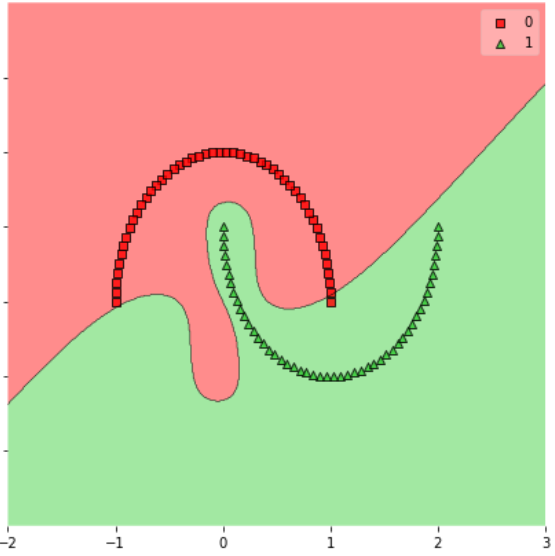

In [ ]:
# Так тоже работает
# NN_mini = Network_multiclass([Linear(2, 10), Tanh(), Linear(10, 10), Tanh(), Linear(10, 10), Tanh(), Linear(10, 2), Softmax()])
# train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.03, max_iter = 2000, debug = 1)

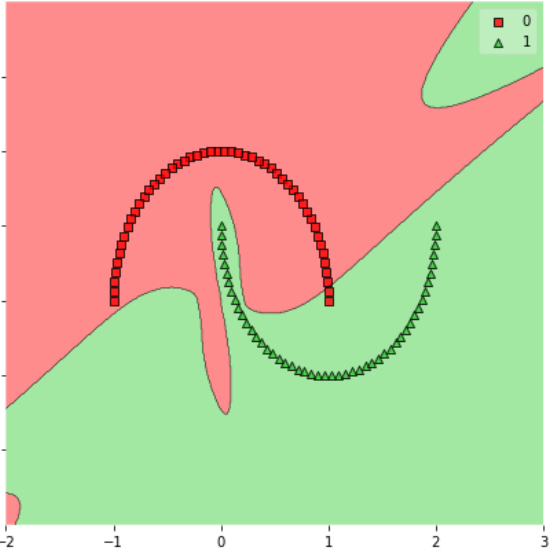

In [ ]:
# и так работает
# NN_mini = Network_multiclass([Linear(2, 10), Tanh(), Linear(10, 10), Tanh(), Linear(10, 2), Softmax()])
# train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.07, max_iter = 2000, debug = 1)

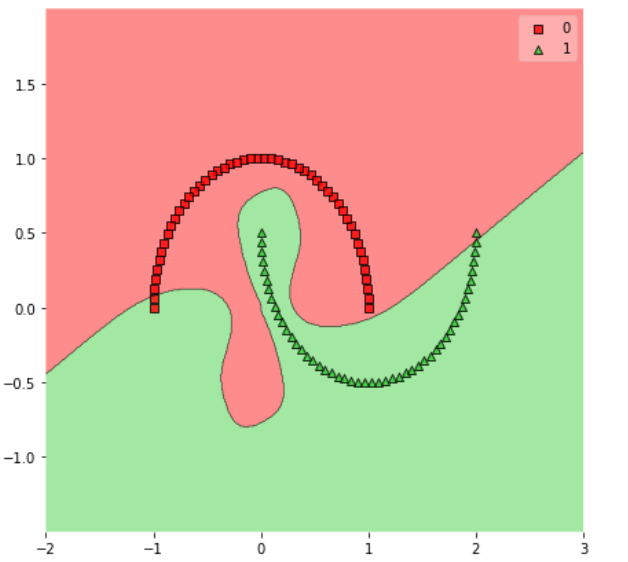

In [ ]:
# и так тоже работает!
# NN_mini = Network_multiclass([Linear(2, 5), Tanh(), Linear(5, 5), Tanh(), Linear(5, 2), Softmax()])
# train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.1, max_iter = 3000, debug = 1)

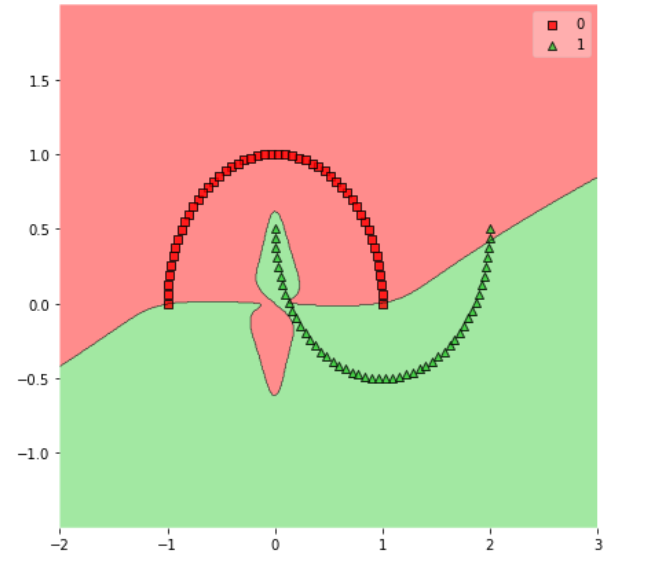

In [ ]:
# И так тоже работает, но через раз - как веса инициализируются, видимо
# NN_mini = Network_multiclass([Linear(2, 3), Tanh(), Linear(3, 3), Tanh(), Linear(3, 2), Softmax()])
# train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.02, max_iter = 10000, debug = 1)

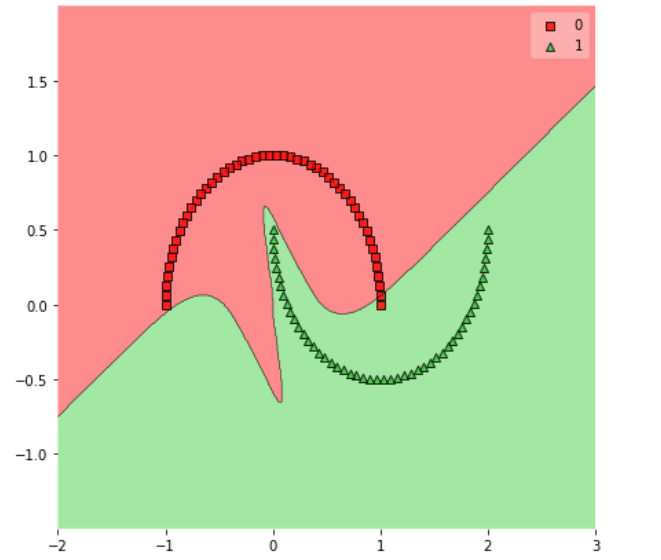

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN_mini, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
# Сигмоида тоже работает
# NN_mini = Network_multiclass([Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 2), Softmax()])
# train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.03, max_iter = 5000, debug = 1)

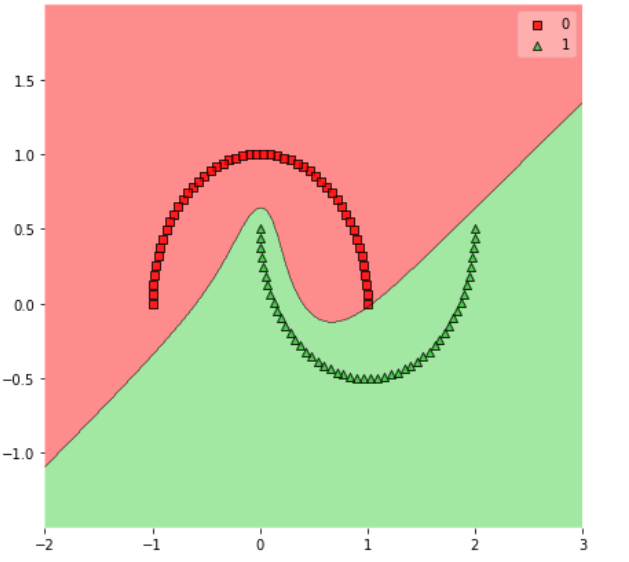

In [ ]:
NN_mini = Network_multiclass([Linear(2, 10), Relu(), Linear(10, 10), Relu(), Linear(10, 2), Softmax()])
train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.001, max_iter = 10000, debug = 0)

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN_mini, colors = 'red,limegreen,blue,gray,cyan')
plt.show()

In [ ]:
class LeakyRelu:
    
    def __init__(self, alpha):
        self.X_ = None
        self.alpha = alpha
    
    def forward(self, X):
        self.X_ = X
        return np.where(X <= 0, X * self.alpha, X)
    
    def backward(self, upstr_grad, lr = None, debug = 0):
        return upstr_grad * np.where(self.X_ <= 0, self.alpha, 1)

In [ ]:
NN_mini = Network_multiclass([Linear(2, 10), Tanh(), Linear(10, 10), LeakyRelu(0.05), Linear(10, 2), Softmax()])
train_network_multiclass(NN_mini, train_X, train_Y, lr = 0.001, max_iter = 10000, debug = 0)

In [ ]:
fig = plt.figure(figsize=(7, 7))
plot_decision_regions(train_X, train_Y, NN_mini, colors = 'red,limegreen,blue,gray,cyan')
plt.show()